# Sarcasm Detection on NewsHeadline with LSTM & GloVe 

### 1- Preliminaries

In [ ]:
# numpy module for numeric data processing and vectorization
import numpy as np

# pandas module for opening dataset & processing it
import pandas as pd

# for text cleaning purposes
import re

# to fix random seeds 
import os
import random
import nltk
from nltk.corpus import stopwords

# for making progress bar
from tqdm.notebook import tqdm

# for making plots
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# for making word cloud
from wordcloud import WordCloud, STOPWORDS

# evaluation metrics 
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

# keras for deep learning model creation
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.utils import plot_model

# other modules
import tensorflow as tf
import torch

### 2- Reading the dataset 
Pandas is the best when it comes to read a CSV file!

In [ ]:
df = pd.read_json("/content/drive/MyDrive/Sarcasm_Headlines_Dataset_v2.json",lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


### 3- Pre-processing
Now, Let's apply pre-processing operations on our text data.<br>
One of the most common things we can do is to remove `contractions`.<br>


In [ ]:
df.isna().sum() 

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [ ]:
# Since the article link is not required for analysis, thus, we can delete it.
df = df.iloc[:, :2] 
df.head(3)

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes


In [ ]:
nltk.download('stopwords')
stop = list(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Transforming text into lower case
def lowercase(text): 
      return text.lower()

# Removing stopwords to avoid overfitting
def remove_stopwords(text):  
    mylist = []
    for i in text.split():
        if i not in stop:
            mylist.append(i)
    return " ".join(mylist)

# Removing punctuations
def remove_punct(text): 
      return re.sub('[^a-z]+',' ',text)

def cleanmepls(text):
  text = lowercase(text)
  text = remove_punct(text)
  text = remove_stopwords(text)
  return text

df['headline_new'] = df['headline'].apply(cleanmepls)

In [ ]:
#observe changes
df.head(20) 

,is_sarcastic,headline,headline_new
0,1,thirtysomething scientists unveil doomsday clo...,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...,dem rep totally nails congress falling short g...
2,0,eat your veggies: 9 deliciously different recipes,eat veggies deliciously different recipes
3,1,inclement weather prevents liar from getting t...,inclement weather prevents liar getting work
4,1,mother comes pretty close to using word 'strea...,mother comes pretty close using word streaming...
5,0,my white inheritance,white inheritance
6,0,5 ways to file your taxes with less stress,ways file taxes less stress
7,1,richard branson's global-warming donation near...,richard branson global warming donation nearly...
8,1,shadow government getting too large to meet in...,shadow government getting large meet marriott ...
9,0,lots of parents know this scenario,lots parents know scenario


In [ ]:
del df['headline']

### 4- Tokenization

In [ ]:
embedding_dim = 200
max_length = 20 
trunc_type = 'post'
pad_type = 'post'
training_size = len(df)
test_portion = 0.3
# print(training_size)

28619

In [ ]:
# Creating the tokenizer object
tokenizer = Tokenizer()
# Creating word index dictionary
tokenizer.fit_on_texts(df['headline_new']) 
word_index_dict = tokenizer.word_index 
vocab_size = len(word_index_dict) + 1
# print(vocab_size)

25766


In [ ]:
# Transforming the words to the vector representation
sequence = tokenizer.texts_to_sequences(df['headline_new']) 
# Some padding for having the same length
padding = pad_sequences(sequences=sequence, maxlen=max_length, padding=pad_type, truncating=trunc_type) 
split = int(test_portion*training_size)
# print(split)

8585

In [ ]:
test_sequences = padding[0:split] 
training_sequences = padding[split:]

labels = df['is_sarcastic']
test_labels = labels[0:split]
training_labels = labels[split:]

### 5- Embedding

In [ ]:
# Let's create an embedding dictionary with the words and their 200-D representation in the given file.
embedding_dict = {}
with open('/content/drive/MyDrive/glove.twitter.27B.200d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float64')
        embedding_dict[word] = coefs

In [ ]:
# Creating embedding matrix for saving the weights
embedding_matrix = np.zeros((vocab_size, embedding_dim)) 
embedding_matrix.shape

(25766, 200)

In [ ]:
# Updating embeddings matrix with their GloVe weights
for word, index in word_index_dict.items(): 
  embedding_vector = embedding_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [ ]:
# Converting to array for convenience 
test_sequences = np.asarray(test_sequences, dtype='int64') 
training_sequences = np.asarray(training_sequences, dtype='int64')

test_labels = np.asarray(test_labels)
training_labels = np.asarray(training_labels)

### 6- Building the model

In [ ]:
# We are using LSTM gate to handle the vanishing gradient problem due to long term dependancies
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.4, return_sequences=False)), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           5153200   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               135680    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 5,289,009
Trainable params: 135,809
Non-trainable params: 5,153,200
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics='accuracy')

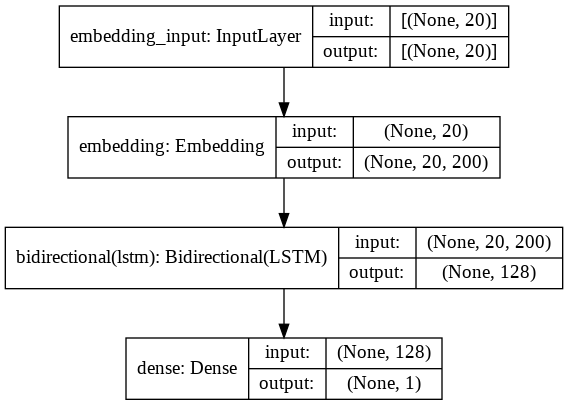

In [ ]:
plot_model(model, show_shapes=True)

### 7- Training the model

In [ ]:
num_epochs = 10
history = model.fit(x=training_sequences, y=training_labels, validation_data=(test_sequences, test_labels), epochs = num_epochs, verbose = 1)

Epoch 1/10
627/627 [==============================] - 22s 29ms/step - loss: 0.5508 - accuracy: 0.7107 - val_loss: 0.4442 - val_accuracy: 0.7932
Epoch 2/10
627/627 [==============================] - 17s 28ms/step - loss: 0.4511 - accuracy: 0.7862 - val_loss: 0.4230 - val_accuracy: 0.8055
Epoch 3/10
627/627 [==============================] - 17s 28ms/step - loss: 0.3928 - accuracy: 0.8180 - val_loss: 0.4055 - val_accuracy: 0.8128
Epoch 4/10
627/627 [==============================] - 18s 28ms/step - loss: 0.3710 - accuracy: 0.8310 - val_loss: 0.3792 - val_accuracy: 0.8267
Epoch 5/10
627/627 [==============================] - 18s 28ms/step - loss: 0.3425 - accuracy: 0.8473 - val_loss: 0.3755 - val_accuracy: 0.8341
Epoch 6/10
627/627 [==============================] - 18s 28ms/step - loss: 0.3062 - accuracy: 0.8655 - val_loss: 0.3756 - val_accuracy: 0.8351
Epoch 7/10
627/627 [==============================] - 18s 28ms/step - loss: 0.2901 - accuracy: 0.8755 - val_loss: 0.3992 - val_accuracy:

### 8- Result of the model 

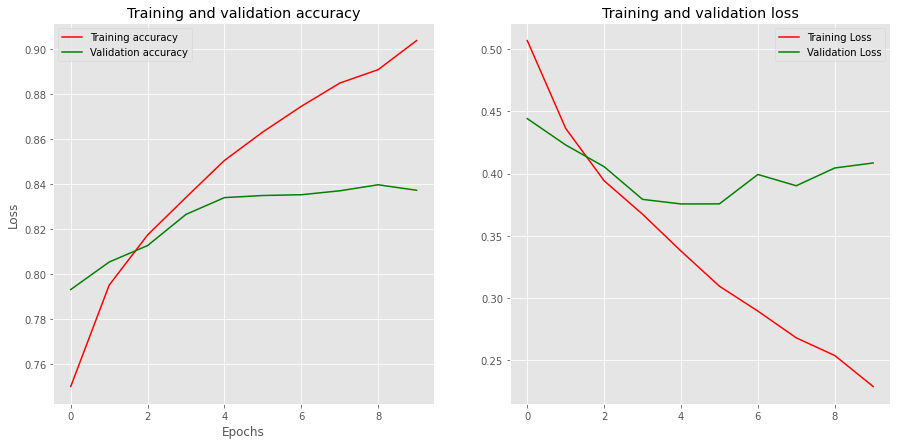

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = [i for i in range(10)]

fig, ax = plt.subplots(1,2)

ax[0].plot(epochs, acc, 'r', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'g', label='Validation accuracy')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")


ax[1].plot(epochs, loss, 'r', label='Training Loss')
ax[1].plot(epochs, val_loss, 'g', label='Validation Loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

fig.set_size_inches(15,7)
plt.show()

In [ ]:
# Handling the overfitting by stopping the train process after 4 iterations.
num_epochs = 4
history = model.fit(x=training_sequences, y=training_labels, validation_data=(test_sequences, test_labels), epochs = num_epochs, verbose = 1)

Epoch 1/4
627/627 [==============================] - 18s 29ms/step - loss: 0.2199 - accuracy: 0.9062 - val_loss: 0.4107 - val_accuracy: 0.8315
Epoch 2/4
627/627 [==============================] - 18s 29ms/step - loss: 0.2059 - accuracy: 0.9139 - val_loss: 0.4230 - val_accuracy: 0.8397
Epoch 3/4
627/627 [==============================] - 18s 29ms/step - loss: 0.1997 - accuracy: 0.9165 - val_loss: 0.4175 - val_accuracy: 0.8411
Epoch 4/4
627/627 [==============================] - 18s 29ms/step - loss: 0.1833 - accuracy: 0.9249 - val_loss: 0.4376 - val_accuracy: 0.8408


In [ ]:
print("Training Loss and Accuracy: ")
loss, accuracy = model.evaluate(training_sequences, training_labels, verbose = 1)
print("Validation Loss and Accuracy: ")
loss, accuracy = model.evaluate(test_sequences, test_labels, verbose = 1)

Training Loss and Accuracy: 
627/627 [==============================] - 5s 8ms/step - loss: 0.0684 - accuracy: 0.9810
Validation Loss and Accuracy: 
269/269 [==============================] - 2s 8ms/step - loss: 0.4376 - accuracy: 0.8408


In [ ]:
y_pred = model.predict_classes(test_sequences)
y_pred[:5]

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[1],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [ ]:
precision_recall_fscore_support(test_labels, y_pred, average='macro')

(0.840788336967133, 0.8402661242740684, 0.8404627575736653, None)

In [ ]:
cm = confusion_matrix(test_labels,y_pred)
cm

array([[3797,  646],
       [ 721, 3421]])

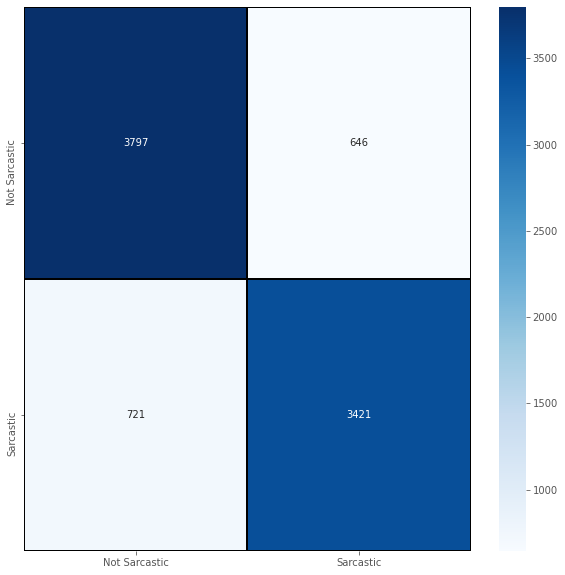

In [ ]:
cm = pd.DataFrame(cm , index = ['Not Sarcastic','Sarcastic'] , columns = ['Not Sarcastic','Sarcastic'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Not Sarcastic','Sarcastic'] , yticklabels = ['Not Sarcastic','Sarcastic'])